In [29]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from xgboost.testing import root_mean_square

from train_and_evaluate import load_train_test_data

from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

ModuleNotFoundError: No module named 'pytest'

In [24]:


df_train, df_test, X_train, y_train, X_test, y_test, predictors, predictands = load_train_test_data(predictand='clf')
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Convert pandas DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f'train_loader: {train_loader} \n test_loader: {test_loader}' )
print(f'size of train_loader: {len(train_loader)} \n size of test_loader: {len(test_loader)}')

Train and test data loaded successfully! Missing values dropped.
X_train shape: (207436, 25), y_train shape: (207436, 1)
train_loader: <torch.utils.data.dataloader.DataLoader object at 0x76dfc1757550> 
 test_loader: <torch.utils.data.dataloader.DataLoader object at 0x76dfc1781890>
size of train_loader: 6483 
 size of test_loader: 1421


Neural Network Architecture

In [11]:
class MultiTargetRegressor(nn.Module):
    """Neural network for multi-target regression"""
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            # Input layer to first hidden layer
            nn.Linear(input_size, 128),
            nn.ReLU(),

            # First hidden layer to second hidden layer
            nn.Linear(128, 64),
            nn.ReLU(),

            # Second hidden layer to output layer
            nn.Linear(64, output_size)
        )

        # Initialize weights using Kaiming He initialization for ReLU
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        """Defines forward pass through network"""
        return self.layers(x)

Model Training Function:

In [14]:
def train_model(model, train_loader, test_loader, num_epochs=100):
    """Training loop with validation monitoring"""
    # Loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error for regression
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

    # Track losses for visualization
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Reset gradients
            outputs = model(X_batch)  # Forward pass
            loss = criterion(outputs, y_batch)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            epoch_train_loss += loss.item()

        # Validation phase
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                epoch_val_loss += loss.item()

        # Calculate average losses
        train_loss = epoch_train_loss / len(train_loader)
        val_loss = epoch_val_loss / len(test_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Update learning rate
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

    return train_losses, val_losses


Model Evaluation:

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(model, X_test_tensor, y_test):
    """Generate predictions and calculate metrics"""
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)

    # Convert to numpy for sklearn metrics
    y_pred = y_pred_tensor.numpy()

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Method #2 from search results
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Display metrics
    print("\nFinal Model Evaluation:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")  # Added from search result [1][2]
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    return y_pred

Visualisation

In [20]:
def plot_loss_curves(train_losses, val_losses):
    """Plot training and validation loss curves"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Execution

In [34]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = MultiTargetRegressor(input_size, output_size)

# Train model
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=25
)

#

/home/sparashar/Installed/miniconda3/envs/calisma/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


KeyboardInterrupt: 

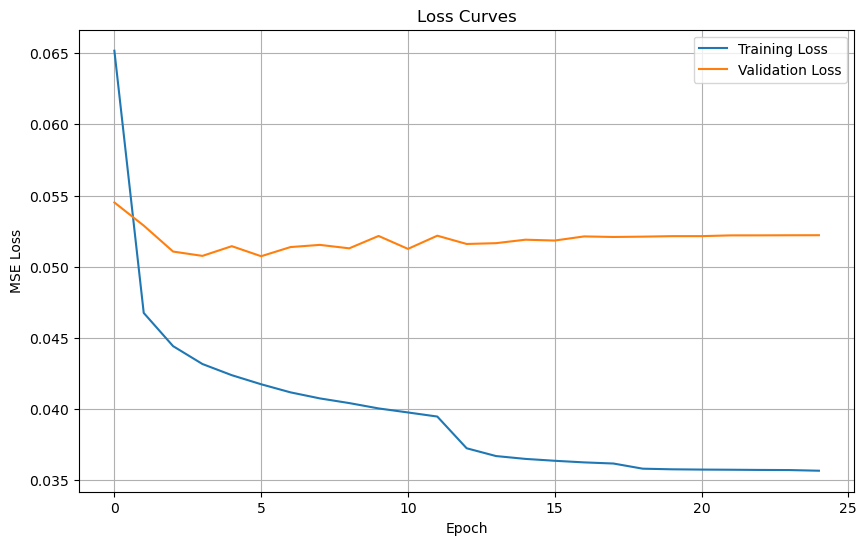


Final Model Evaluation:
MSE: 0.0642
RMSE: 0.2533
MAE: 0.2036
R²: 0.3629


array([[0.68069816],
       [0.81432545],
       [0.7372806 ],
       ...,
       [0.5155256 ],
       [0.5023613 ],
       [0.37010124]], dtype=float32)

In [35]:
 #Visualize training progress
plot_loss_curves(train_losses=train_losses, val_losses=val_losses)

# Final evaluation
evaluate_model(model=model, X_test_tensor=X_test_tensor, y_test=y_test)
#y_pred = evaluate_model(model, X_test_tensor, y_test)